<a href="https://colab.research.google.com/github/suryasrijajamalapuram/Stock-Price-Predictor/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (1825, 7)
         Date         High          Low         Open        Close  \
0  2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1  2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2  2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3  2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4  2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  


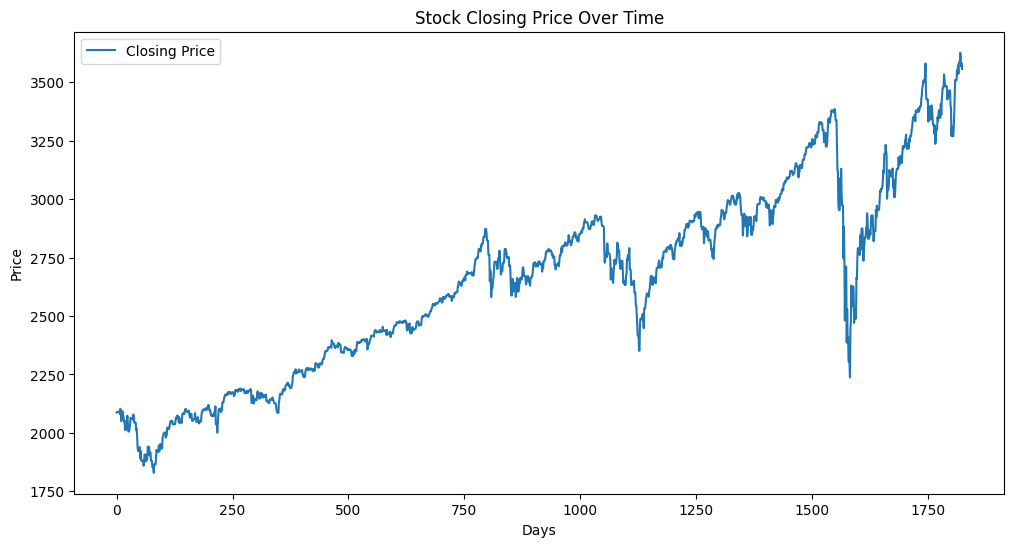

In [2]:
#Import libraries and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv("/content/yahoo_stock.csv")
print("Dataset shape:", data.shape)
print(data.head())

# Plot closing price
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Closing Price')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [3]:
# Data preprocessing for LSTM
from sklearn.preprocessing import MinMaxScaler

# Use 'Close' column as target
closing_prices = data['Close'].values
closing_prices = closing_prices.reshape(-1,1)

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(closing_prices)

# Create sequences (X = previous 60 days, y = next day price)
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_prices)):
    X.append(scaled_prices[i-sequence_length:i, 0])
    y.append(scaled_prices[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1765, 60, 1)
y shape: (1765,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0313 - val_loss: 0.0020
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0

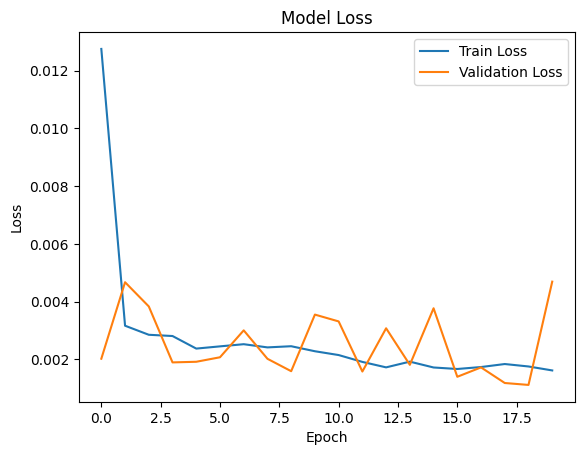

In [4]:
# Build and train LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)

# Plot training & validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


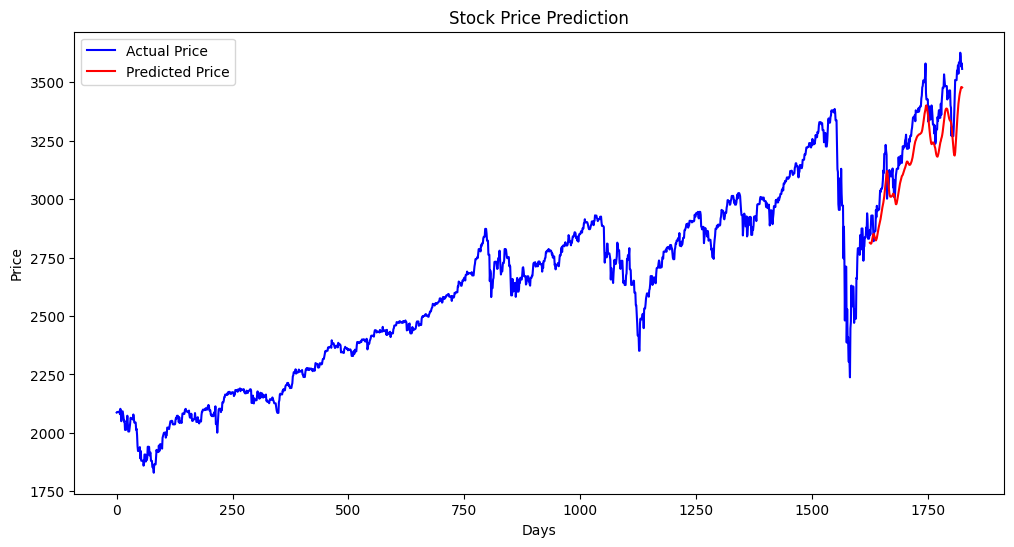

In [5]:
# Testing & visualization
# Use last 200 days for testing
test_data_len = 200
test_prices = closing_prices[-test_data_len:]
total_data = np.concatenate((closing_prices[:-test_data_len], closing_prices[-test_data_len:]), axis=0)

# Prepare test inputs
inputs = scaled_prices[-(test_data_len + sequence_length):]
X_test = []

for i in range(sequence_length, len(inputs)):
    X_test.append(inputs[i-sequence_length:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(len(closing_prices)), closing_prices, color='blue', label='Actual Price')
plt.plot(range(len(closing_prices)-test_data_len, len(closing_prices)), predicted_prices, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverse scale y_test
y_test = closing_prices[-test_data_len:]

rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
mae = mean_absolute_error(y_test, predicted_prices)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 119.47
MAE: 107.84


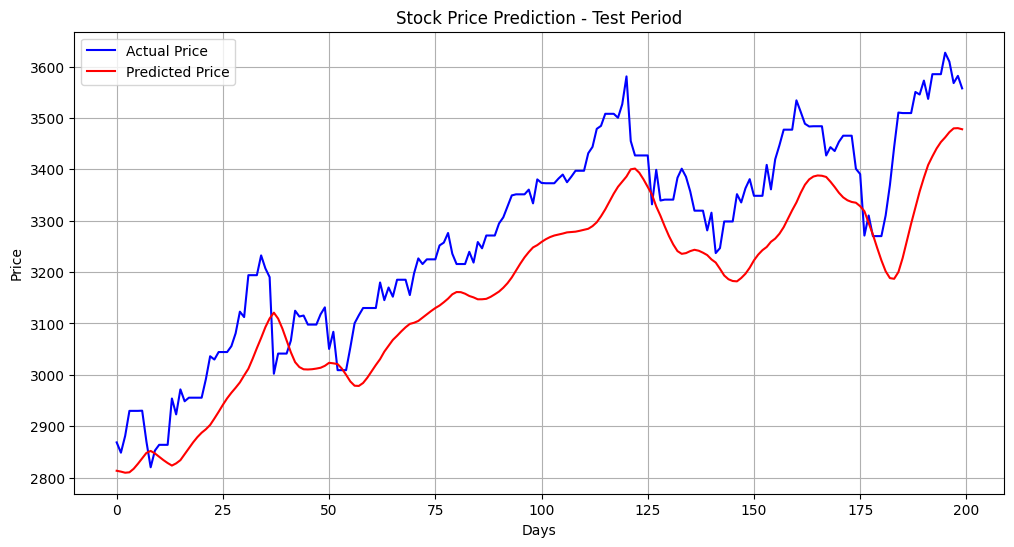

In [8]:
plt.figure(figsize=(12,6))
plt.plot(range(test_data_len), y_test, color='blue', label='Actual Price')
plt.plot(range(test_data_len), predicted_prices, color='red', label='Predicted Price')
plt.title('Stock Price Prediction - Test Period')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicted_prices)
print(f"R² Score: {r2:.3f}")

R² Score: 0.624


RMSE: 119.47
MAE: 107.84
R² Score: 0.624


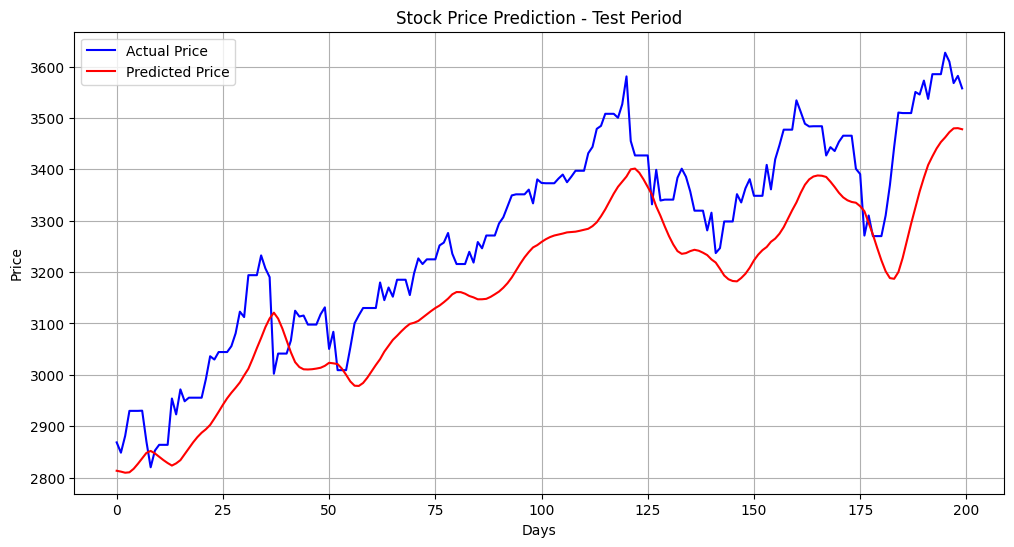

In [10]:
# 5️⃣ Final evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
mae = mean_absolute_error(y_test, predicted_prices)
r2 = r2_score(y_test, predicted_prices)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.3f}")

# Zoomed-in plot for test period
plt.figure(figsize=(12,6))
plt.plot(range(test_data_len), y_test, color='blue', label='Actual Price')
plt.plot(range(test_data_len), predicted_prices, color='red', label='Predicted Price')
plt.title('Stock Price Prediction - Test Period')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()